In [1]:
# for data processing
import pandas as pd
import geopandas as gpd
# for visualisation
import matplotlib.pyplot as plt
# for network analysis
import osmnx as ox
import networkx as nx
import spaghetti
# for handling projections
import pyproj

import warnings
warnings.filterwarnings('ignore')

In [2]:
# all the urls containing the csv files for the road traffic accidents data
urls = ['https://datamillnorth.org/download/road-traffic-accidents/8e6585f6-e627-4258-b16f-ca3858c0cc67/Traffic%2520accidents_2019_Leeds.csv',
        'https://datamillnorth.org/download/road-traffic-accidents/8c100249-09c5-4aac-91c1-9c7c3656892b/RTC%25202018_Leeds.csv',
        'https://datamillnorth.org/download/road-traffic-accidents/ca7e4598-2677-48f8-be11-13fd57b91640/Leeds_RTC_2017.csv',
        'https://datamillnorth.org/download/road-traffic-accidents/b2c7ebba-312a-4b3d-a324-6a5eda85fa5b/Copy%2520of%2520Leeds_RTC_2016.csv',
        'https://datamillnorth.org/download/road-traffic-accidents/df98a6dd-704e-46a9-9d6d-39d608987cdf/2015.csv',
        'https://datamillnorth.org/download/road-traffic-accidents/fa7bb4b9-e4e5-41fd-a1c8-49103b35a60f/2014.csv',
        'https://datamillnorth.org/download/road-traffic-accidents/56550461-ea6c-47d7-be61-73339b132547/2013.csv',
        'https://datamillnorth.org/download/road-traffic-accidents/6ff5a09b-666a-4420-92ea-b6817b4a0f5c/2012.csv',
        'https://datamillnorth.org/download/road-traffic-accidents/9204d06c-8e43-42d3-9ffa-87d806661801/2011.csv',
        'https://datamillnorth.org/download/road-traffic-accidents/1ead4f5f-3636-4b8f-830c-7d2cc6f16084/2010.csv',
        'https://datamillnorth.org/download/road-traffic-accidents/288d2de3-0227-4ff0-b537-2546b712cf00/2009.csv']

# read in the csv files and convert them to geodataframes
# store the gdfs in a list
gdfs = []
for url in urls:
    df = pd.read_csv(url, encoding='latin1') # use latin1 encoding to ensure the data is read in correctly
    # crs='EPSG:27700' for lat/long coordinates
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[df.columns[1]], df[df.columns[2]]), crs='EPSG:27700')
    gdfs.append(gdf)

In [3]:
# concatenate the gdfs into one
gdf = pd.concat(gdfs, ignore_index=True)

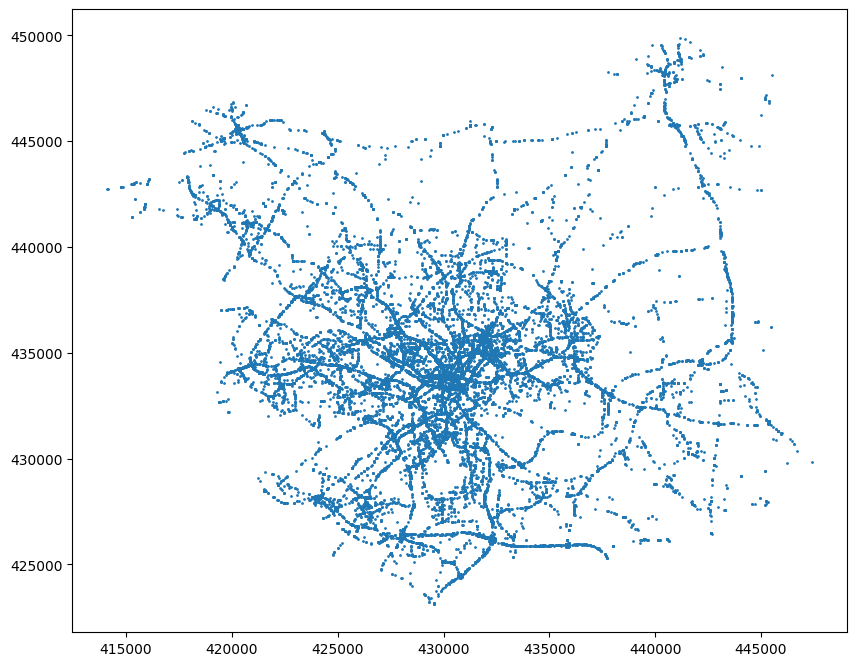

In [4]:
# visualise all the accidents in Leeds
gdf.plot(markersize=1, figsize=(10,10))
plt.show()

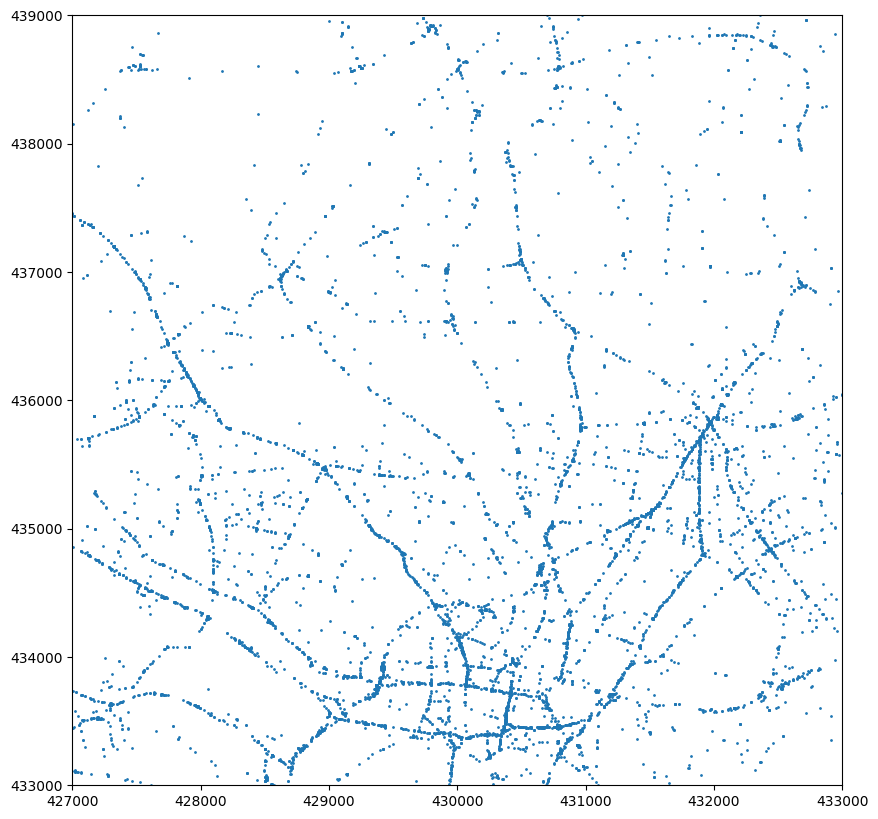

In [5]:
# zoom in to a dense area
gdf.plot(markersize=1, figsize=(10,10))
plt.xlim(427000, 433000)
plt.ylim(433000, 439000)
plt.show()

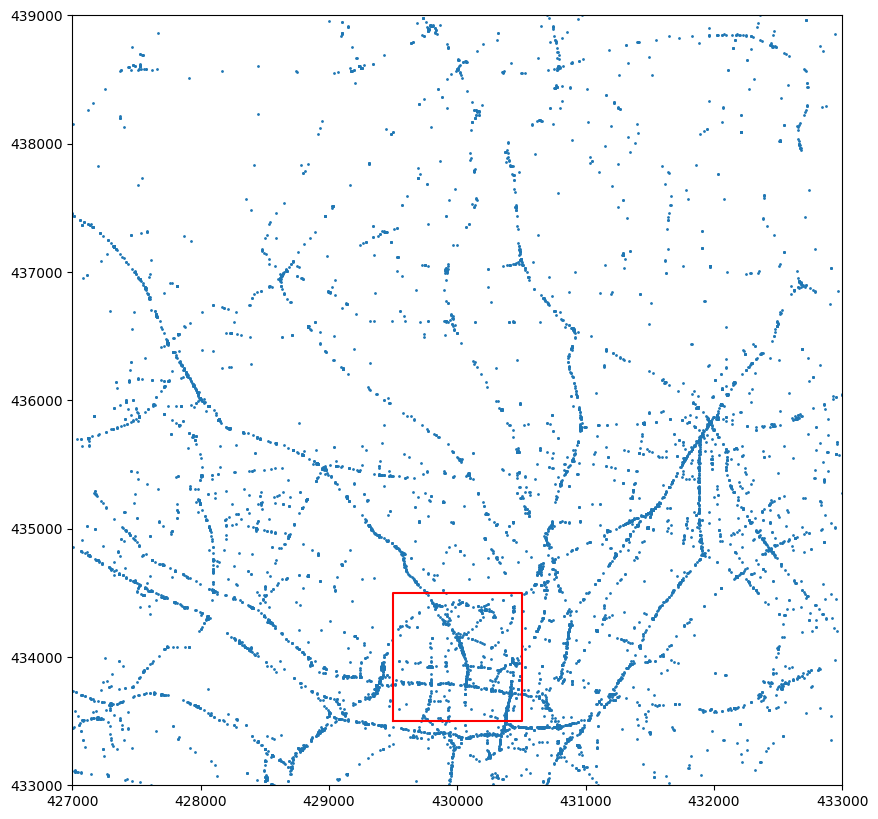

In [6]:
from shapely.geometry import Polygon

# select a 1 km x 1 km area of interest
CENTRE_OF_AREA = (430000, 434000)
AREA_OF_INTEREST = Polygon([(CENTRE_OF_AREA[0]-500, CENTRE_OF_AREA[1]-500),
                            (CENTRE_OF_AREA[0]+500, CENTRE_OF_AREA[1]-500),
                            (CENTRE_OF_AREA[0]+500, CENTRE_OF_AREA[1]+500),
                            (CENTRE_OF_AREA[0]-500, CENTRE_OF_AREA[1]+500)])

# visualise the area of interest
fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(ax=ax, markersize=1)
plt.xlim(427000, 433000)
plt.ylim(433000, 439000)
plt.plot(*AREA_OF_INTEREST.exterior.xy, color='red')
plt.show()

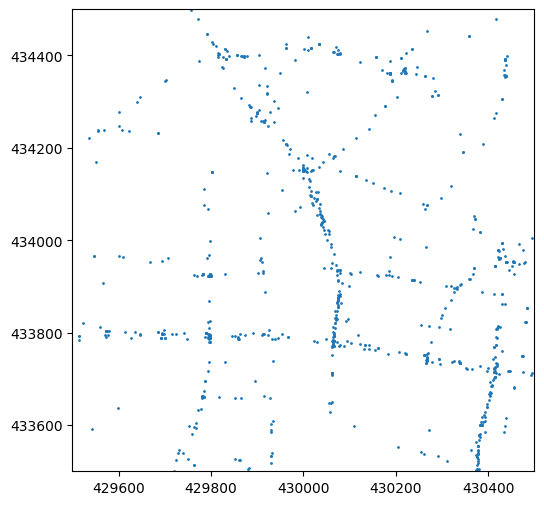

In [7]:
# zoom in to the area of interest
gdf.plot(markersize=1, figsize=(6,6))
plt.xlim(429500, 430500)
plt.ylim(433500, 434500)
plt.show()

In [8]:
# select the accidents within the area of interest
gdf_clipped = gdf[gdf['geometry'].within(AREA_OF_INTEREST)]
gdf_clipped = gdf_clipped[['Accident Date', 'geometry']].reset_index(drop=True)

# check the number of accidents
print('Number of accidents:', len(gdf_clipped))

In [9]:
from shapely.ops import transform

# reproject both the gdf and the area of interest to lat/long coordinates for osmnx
gdf_clipped = gdf_clipped.to_crs('EPSG:4326')
project = pyproj.Transformer.from_crs(pyproj.CRS('EPSG:27700'), pyproj.CRS('EPSG:4326'), always_xy=True).transform
AREA_OF_INTEREST = transform(project, AREA_OF_INTEREST)

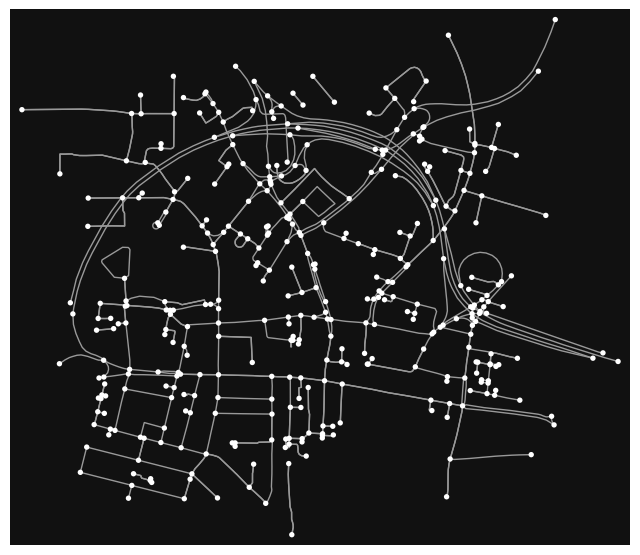

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [10]:
# retrieve the road network within the area of interest
G = ox.graph_from_polygon(AREA_OF_INTEREST, network_type='drive_service', truncate_by_edge=True, retain_all=True)
# and visualise it
ox.plot_graph(G)

In [11]:
# function to calculate the spatial diameter
def spatial_diameter(G):
    diameter = 0
    for u in G.nodes():
        # Find the shortest path from u to all other nodes
        dist = nx.shortest_path_length(G, source=u, weight='length')
        # Find the most distant node from u
        v = max(dist, key=dist.get)
        # Find the shortest path from u to v
        path = nx.shortest_path(G, source=u, target=v, weight='length')
        # Calculate the weighted length of the path
        path_length = sum(dict(G[s][e])[0]['length'] for s, e in zip(path[:-1], path[1:]))
        # Update the diameter if the new path is longer
        diameter = max(diameter, path_length)
    return diameter

In [12]:
spatial_diameter(G)

3012.5240000000003

In [13]:
# characteristics of the road network
ox.stats.basic_stats(G, area=1000000)

{'n': 387,
 'm': 675,
 'k_avg': 3.488372093023256,
 'edge_length_total': 42179.20699999991,
 'edge_length_avg': 62.487714074073935,
 'streets_per_node_avg': 2.5891472868217056,
 'streets_per_node_counts': {0: 0, 1: 101, 2: 5, 3: 237, 4: 40, 5: 4},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.26098191214470284,
  2: 0.012919896640826873,
  3: 0.6124031007751938,
  4: 0.10335917312661498,
  5: 0.0103359173126615},
 'intersection_count': 286,
 'street_length_total': 31194.143000000033,
 'street_segment_count': 469,
 'street_length_avg': 66.5120319829425,
 'circuity_avg': 1.0662223015902033,
 'self_loop_proportion': 0.0042643923240938165,
 'node_density_km': 387.0,
 'intersection_density_km': 286.0,
 'edge_density_km': 42179.20699999991,
 'street_density_km': 31194.143000000033}

The network is planar: False


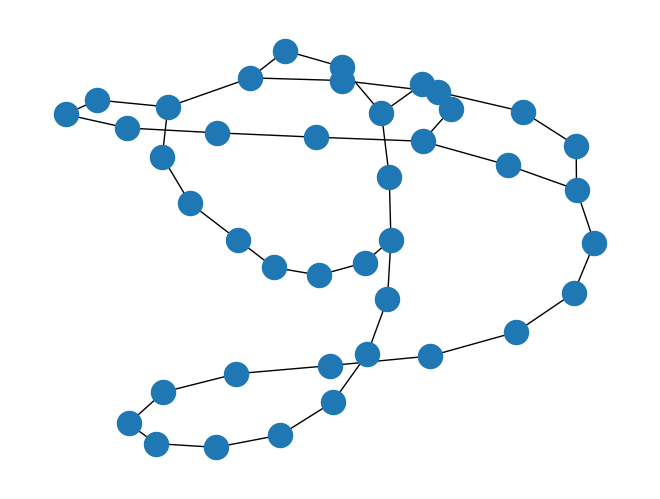

In [14]:
# check if the network is planar
is_planar, counterexample = nx.check_planarity(G, counterexample=True)
print(f'The network is planar: {is_planar}')
# and visualise the counterexample if it is not planar
nx.draw(counterexample)

In [15]:
from shapely.geometry import LineString

# extract node coordinates
lon_values = nx.get_node_attributes(G, 'x')
lat_values = nx.get_node_attributes(G, 'y')

# extract edge information
edges_with_geom = list(G.edges(data=True))

# fill in the missing geometry information using the node coordinates
for edge in edges_with_geom:
    if 'geometry' not in edge[2]:
        edge[2]['geometry'] = LineString([(lon_values[edge[0]], lat_values[edge[0]]),
                                          (lon_values[edge[1]], lat_values[edge[1]])])

edges_with_geom[0]

(9791132,
 3871120536,
 {'osmid': 745709508,
  'oneway': False,
  'lanes': '2',
  'name': 'King Street',
  'highway': 'tertiary',
  'maxspeed': '30 mph',
  'reversed': False,
  'length': 51.251,
  'geometry': <shapely.geometry.linestring.LineString at 0x162810a60>})

In [16]:
# load the edges into a geodataframe
edges_gdf = gpd.GeoDataFrame(pd.DataFrame([edge[2] for edge in edges_with_geom]), geometry='geometry')
edges_gdf.head()

,osmid,oneway,lanes,name,highway,maxspeed,reversed,length,geometry,access,ref,tunnel,bridge,junction,service
0,745709508,False,2,King Street,tertiary,30 mph,False,51.251,"LINESTRING (-1.55041 53.79679, -1.55038 53.796...",NaN,NaN,NaN,NaN,NaN,NaN
1,5944464,True,NaN,York Place,unclassified,20 mph,False,133.623,"LINESTRING (-1.55440 53.79739, -1.55433 53.797...",NaN,NaN,NaN,NaN,NaN,NaN
2,609734125,True,NaN,Calverley Street,tertiary,20 mph,False,35.916,"LINESTRING (-1.54910 53.80077, -1.54910 53.80109)",NaN,NaN,NaN,NaN,NaN,NaN
3,175145751,True,2,Great George Street,tertiary,30 mph,False,116.220,"LINESTRING (-1.54910 53.80077, -1.54848 53.800...",NaN,NaN,NaN,NaN,NaN,NaN
4,609729545,False,NaN,Calverley Street,tertiary,20 mph,True,18.050,"LINESTRING (-1.54931 53.80254, -1.54922 53.80239)",NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# reproject both gdfs to the same crs (British National Grid) for easier calculation of distance
edges_gdf = edges_gdf.set_crs('EPSG:4326')
edges_gdf = edges_gdf.to_crs('EPSG:27700')
gdf_clipped = gdf_clipped.to_crs('EPSG:27700')

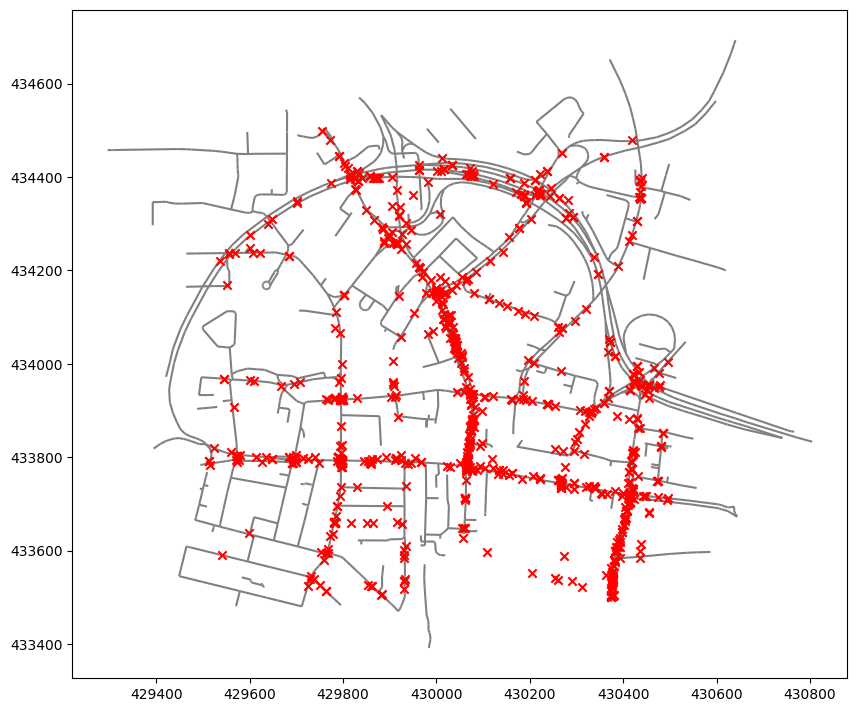

In [18]:
# create a spaghetti network from the edges geoDataFrame
road_network = spaghetti.Network(in_data=edges_gdf)
# add the accidents to the network
road_network.snapobservations(gdf_clipped, 'accidents', attribute=True)
edge_network_gdf = spaghetti.element_as_gdf(road_network, arcs=True)

# visualise the network with the accidents
base_network = edge_network_gdf.plot(color='grey', figsize=(10,10), zorder=0)
# show the actual locations of the accidents
accidents = spaghetti.element_as_gdf(road_network, pp_name='accidents')
accidents.plot(color='red', marker='x', zorder=1, ax=base_network)
plt.show()

In [19]:
# check the distance between the accidents and its snapped location on the network
# filter out those that are more than 20 metres away
accidents_to_remove = [k for k, v in road_network.pointpatterns['accidents'].dist_snapped.items() if v > 20]
filtered_accidents = gdf_clipped.drop(accidents_to_remove).reset_index(drop=True)

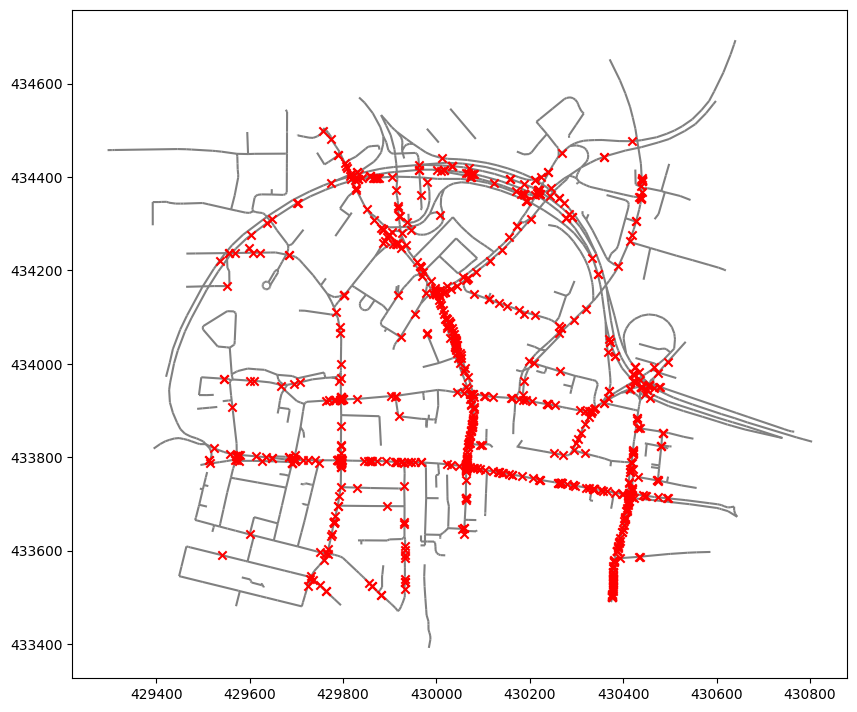

In [20]:
base_network = edge_network_gdf.plot(color='grey', figsize=(10,10), zorder=0)
# add the filtered accidents to the network
road_network.snapobservations(filtered_accidents, 'filtered_accidents', attribute=True)
# show the snapped locations of the filtered accidents
snapped_accidents = spaghetti.element_as_gdf(road_network, pp_name='filtered_accidents', snapped=True)
snapped_accidents.plot(color='red', marker='x', ax=base_network, zorder=1)
plt.show()

In [21]:
# count the number of accidents on each edge
counts = road_network.count_per_link(road_network.pointpatterns['filtered_accidents'].obs_to_arc, graph=False)

# get the weight matrix of the network's edges
weights = road_network.w_network

# get the edge ids and the number of accidents on each edge
edges = weights.neighbors.keys()
values = [counts[e] if e in counts.keys() else 0 for _, e in enumerate(edges)]

In [26]:
from esda.moran import Moran

# calculate the global moran's I using the constructed weight matrix and the number of accidents on each edge
moran = Moran(values, weights)
print(f'Global Moran\'s I: {moran.I:.3f}')
print(f'p-value: {moran.p_sim:.3f}')

Global Moran's I: 0.238
p-value: 0.001


In [27]:
# dist_to_vertex is a dictionary with the snapped accident locations as keys,
# and the distances to the left and right vertices of the snapped edge as values
# The fraction is then calculated as the minimum distance divided by the sum of the two distances (ranging from 0 to 0.5)
frac_accidents = [min(dists.values()) / sum(dists.values()) for _, dists \
    in road_network.pointpatterns['filtered_accidents'].dist_to_vertex.items()]

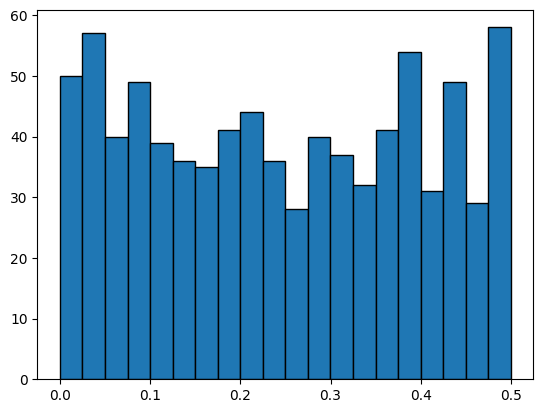

In [28]:
# plot the histogram of the fractions
plt.hist(frac_accidents, bins=20, edgecolor='black')
plt.show()

In [ ]:
kres = road_network.GlobalAutoK(road_network.pointpatterns['accidents'], nsteps=50, permutations=100)

In [ ]:
fig, ax = plt.subplots()

ax.plot(kres.xaxis, kres.observed, "b-", label="Observed")
ax.plot(kres.xaxis, kres.upperenvelope, "r--", label="Upper")
ax.plot(kres.xaxis, kres.lowerenvelope, "k--", label="Lower")

ax.legend(loc="best", fontsize="x-large")
ax.set_xlabel("Distance $(r)$")
ax.set_ylabel("$K(r)$")

fig.tight_layout()